# Setup



https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://www.youtube.com/watch?v=8N-nM3QW7O0&t=817s

In [1]:
!pip install -qq google-play-scraper

In [2]:
!pip install -qq -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

CPython 3.6.9
IPython 5.5.0

pandas 1.1.2
matplotlib 3.2.2
seaborn 0.11.0
google_play_scraper 0.1.1


In [4]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Scrapping the information, creating CSV

In [5]:
app_packages = [
  'com.mcdo.mcdonalds',
  'com.candoit.mostaza',
  'com.grido.app',
  'com.starbucks.ar',
  'ar.burgerking',
  'com.pedidosya',
  'com.rappi.restaurants',
  'com.glovo',
  'com.wabi.customer',
  'com.scanntech.encasa.cliente.superencasa',
  'com.grability.rappi',
  'com.foodbooking.mcdeliverysu',
  'com.foodbooking.kfcsuriname',
  'com.ubercab.eats',
  'com.kfcecuador.kfc',
  'com.grability.rappi',
  'com.falabella.falabellaApp',
  'com.argentina.autosusados',
  'com.tiendamia.android',
  'com.orugga.correoandroid',
  'mobi.adfi.pagofacil'

]

In [6]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, lang='es', country='ar')
    del info['comments']
    app_infos.append(info)

100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


In [7]:
def print_json(json_object):
    json_str = json.dumps(
        json_object, 
        indent=2, 
        sort_keys=True, 
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65293 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65293 missing from current font.
  font.set_text(s, 0, flags=flags)


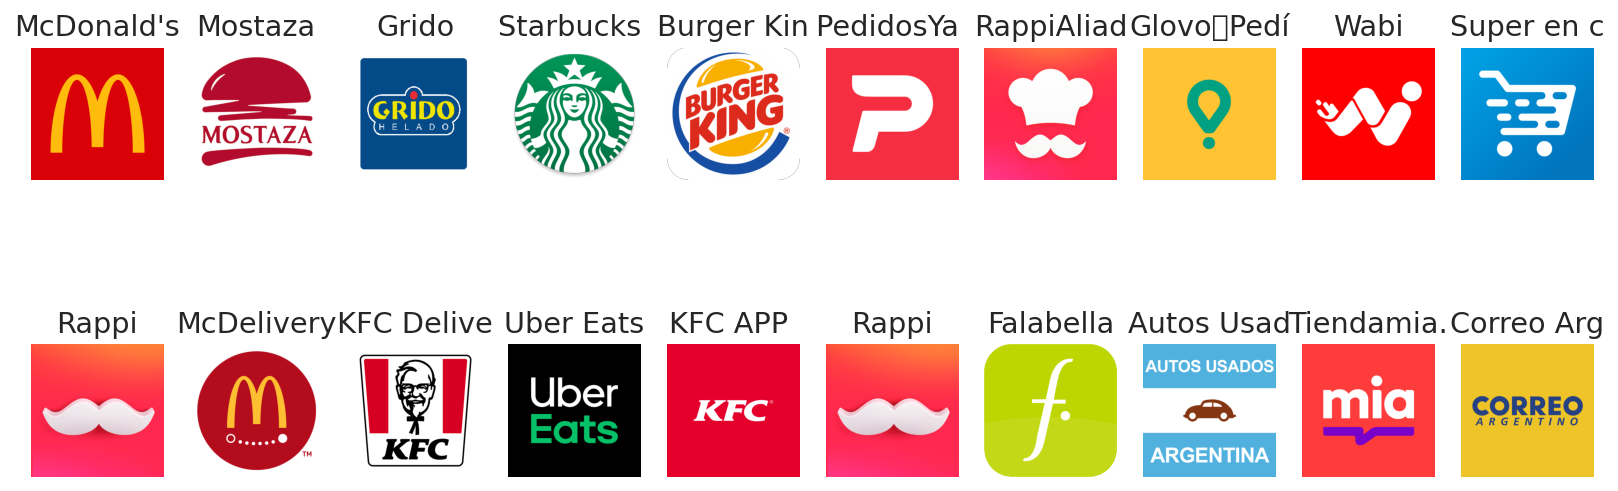

In [8]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

In [9]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

# Scrapping the reviews

In [10]:
app_reviews = []

for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='es',
                country='ar',
                sort=sort_order,
                count= 200 if score == 3 else 100,
                filter_score_with=score
            )
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap
        app_reviews.extend(rvs)

100%|██████████| 21/21 [00:43<00:00,  2.05s/it]


In [11]:
print_json(app_reviews[1])

{
  "appId": "com.mcdo.mcdonalds",
  "at": "2020-10-19 17:52:18",
  "content": "No me dejaba poner la ubicacion Quer\u00eda gastar por lo menos 40 d\u00f3lares con mi familia",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": null,
  "reviewId": "gp:AOqpTOHYvWuCYScmv73zCQrF4jdBp_IkEFqUOpGlzLUMdxwJ8HYfT4evAMGjW6WjnDrv2B-EGGXUJvpXZw7ygnw",
  "score": 1,
  "sortOrder": "newest",
  "thumbsUpCount": 0,
  "userImage": "https://lh3.googleusercontent.com/a-/AOh14Gh9X0QAMM14ZfRCIauhNhULpLxveQcJ84WjB50l4cQ",
  "userName": "Gabriel Moreno Bustillos"
}



In [12]:
len(app_reviews)

8768

In [13]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

# Review Score - Sentiment

In [14]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOH3GLqny4oXihWeoNKKUl0mwTdfocvmZgC_DuU...,priscila soraire,https://lh3.googleusercontent.com/a-/AOh14Ggte...,Deberían llegar hasta mí domicilio 😭 vivo a un...,1,0,2.26.1,2020-10-19 19:33:56,NaN,NaN,newest,com.mcdo.mcdonalds
1,gp:AOqpTOHYvWuCYScmv73zCQrF4jdBp_IkEFqUOpGlzLU...,Gabriel Moreno Bustillos,https://lh3.googleusercontent.com/a-/AOh14Gh9X...,No me dejaba poner la ubicacion Quería gastar ...,1,0,NaN,2020-10-19 17:52:18,NaN,NaN,newest,com.mcdo.mcdonalds
2,gp:AOqpTOGyfkzLRPVgNe3SRFFW68OjruX-nW41md6OC5K...,Mariano Fontela,https://lh3.googleusercontent.com/-Kncak3-_y5I...,"Pésimo, si te cancelan te enteras una hora des...",1,0,NaN,2020-10-19 14:47:13,NaN,NaN,newest,com.mcdo.mcdonalds
3,gp:AOqpTOE6ObJF_4SPrGGVFCRfFnYEm_FGU_yxmhi5fkZ...,Yanina Rossetti,https://lh3.googleusercontent.com/a-/AOh14Ggwg...,Ya no sirve de nada. Con las app de comidas y ...,1,0,2.26.1,2020-10-19 07:39:30,NaN,NaN,newest,com.mcdo.mcdonalds
4,gp:AOqpTOExPzk1QVpjK_VP41hgHemFOFsS79CagUiwjXQ...,Sml Grra,https://lh3.googleusercontent.com/a-/AOh14Gja_...,Trato de crear una cuenta y me sale que no ten...,1,0,NaN,2020-10-19 03:24:30,NaN,NaN,newest,com.mcdo.mcdonalds


In [15]:
df.shape

(8768, 12)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8768 entries, 0 to 8767
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              8768 non-null   object
 1   userName              8768 non-null   object
 2   userImage             8768 non-null   object
 3   content               8768 non-null   object
 4   score                 8768 non-null   int64 
 5   thumbsUpCount         8768 non-null   int64 
 6   reviewCreatedVersion  7266 non-null   object
 7   at                    8768 non-null   object
 8   replyContent          1453 non-null   object
 9   repliedAt             1453 non-null   object
 10  sortOrder             8768 non-null   object
 11  appId                 8768 non-null   object
dtypes: int64(2), object(10)
memory usage: 822.1+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


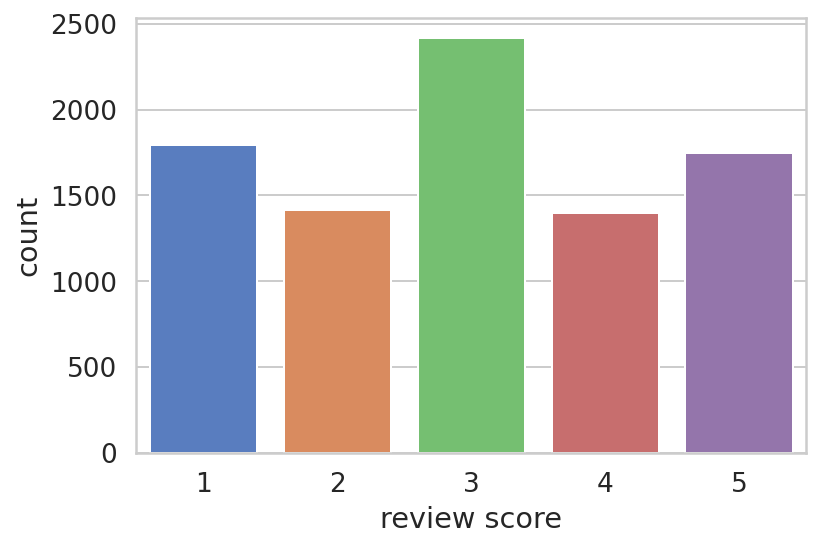

In [17]:
sns.countplot(df.score)
plt.xlabel('review score');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


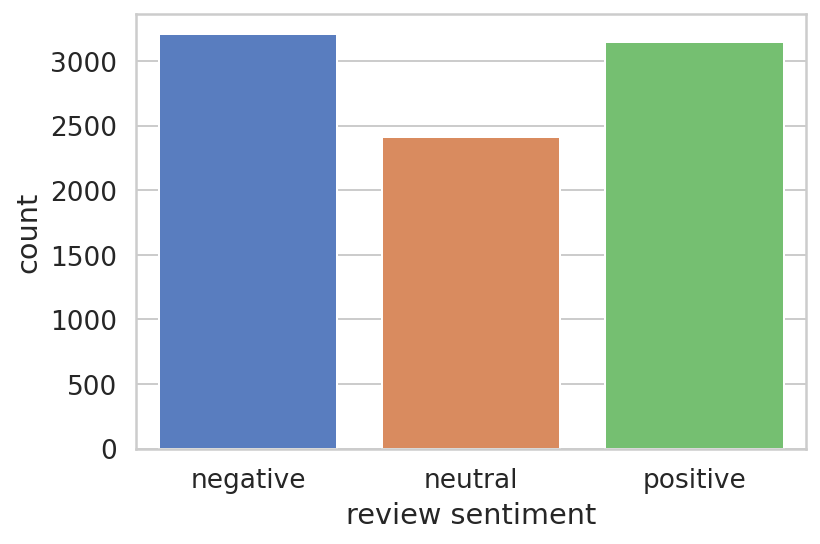

In [18]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [19]:
from sklearn.utils import shuffle
df = shuffle(df)

### Export dataset para Bianca

In [20]:
delivery_app_reviews = df[['content', 'appId', 'sentiment']]
delivery_app_reviews.head()
delivery_app_reviews.to_csv('delivery_app_reviews_bianca.csv')

# Text Preprocessing

In [21]:
!pip install transformers # Installs sacremoses, tokenizers, sentencepiece, transformers

In [22]:
import transformers
import torch


import numpy as np

import copy
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim
from torch.utils import data

HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'

In [23]:
tokenizer = transformers.BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [24]:
simple_text = "Hola, este producto fue una CAGADA! No me llego nunca y se me trababa la aplicación"
tokens = tokenizer.tokenize(simple_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {simple_text}')
print(f' Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: Hola, este producto fue una CAGADA! No me llego nunca y se me trababa la aplicación
 Tokens: ['Hola', ',', 'este', 'producto', 'fue', 'una', 'CA', '##GA', '##DA', '!', 'No', 'me', 'llego', 'nunca', 'y', 'se', 'me', 'traba', '##ba', 'la', 'aplicación']
Token IDs: [1894, 1017, 1365, 4196, 1341, 1108, 12339, 15668, 8739, 1127, 1125, 1129, 15961, 2185, 1042, 1062, 1129, 1381, 1213, 1030, 2283]


## Special Tokens

In [25]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 5)

In [26]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 4)

In [27]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 1)

In [28]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 3)

In [29]:
encoding = tokenizer.encode_plus(
    simple_text,
    max_length=33,
    add_special_tokens=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt' # Jere you can pass tf for tensorflow / Keras
);
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [30]:
encoding['input_ids']

tensor([[    4,  1894,  1017,  1365,  4196,  1341,  1108, 12339, 15668,  8739,
          1127,  1125,  1129, 15961,  2185,  1042,  1062,  1129,  1381,  1213,
          1030,  2283,     5,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1]])

In [31]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Choosing Sequence Length

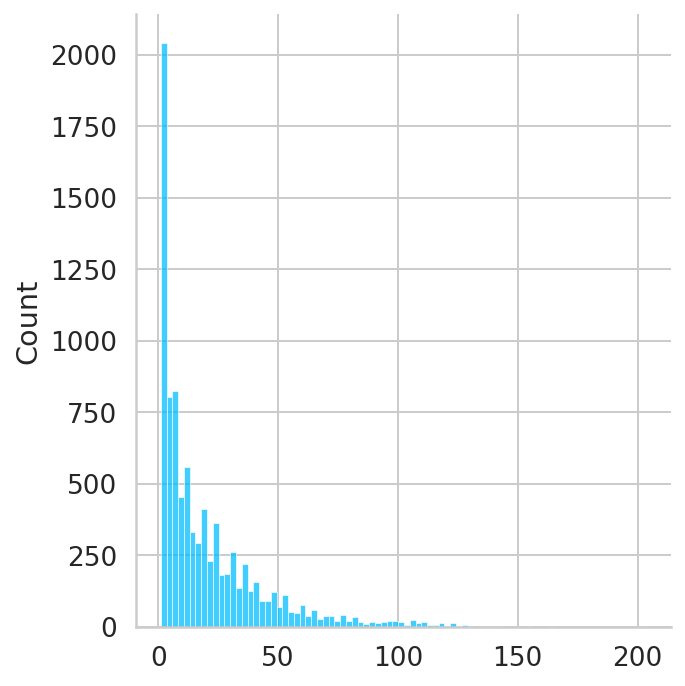

In [32]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.tokenize(txt)
    token_lens.append(len(tokens))

sns.displot(token_lens)

Sequence length entonces de 70

### Create a Dataset

In [33]:
class GPReviewDataset(data.Dataset):
    """https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset"""

    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])

        encoding = tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.long),

        }

In [34]:
MAX_LEN = 70
"""
BATCH_SIZE = 16
EPOCHS = 10
"""
BATCH_SIZE = 64 # 8 16 32 64 128 256
EPOCHS = 4

In [35]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [36]:
df_train.shape, df_val.shape, df_test.shape

((7014, 13), (877, 13), (877, 13))

In [37]:
df.sentiment

5919    0
953     1
3923    1
1825    1
1264    0
       ..
1908    2
5773    0
2380    1
7006    0
6757    2
Name: sentiment, Length: 8768, dtype: int64

In [38]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        review=df.content.to_numpy(),
        target=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [39]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [40]:
data = next(iter(train_data_loader)) # Returns a batch
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [41]:
print(data['input_ids'])

tensor([[    4,  1456,  2536,  ...,     1,     1,     1],
        [    4, 11446, 30938,  ...,     1,     1,     1],
        [    4, 10733,  1038,  ...,     1,     1,     1],
        ...,
        [    4,  1125,  1030,  ...,     1,     1,     1],
        [    4,  6850,     5,  ...,     1,     1,     1],
        [    4,  6772,  2283,  ...,     1,     1,     1]])


In [42]:
print(data['input_ids'].shape)

torch.Size([64, 70])


Creating 8 examples (with 1 feature removed by flatten) with 70 tokens

In [43]:
print(data['targets'])

tensor([1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1,
        2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 2,
        1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2])


[Source](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel)

In [44]:
bert_model = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [45]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
    )

In [46]:
last_hidden_state.shape

torch.Size([1, 33, 768])

In [47]:
pooled_output.shape

torch.Size([1, 768])

In [48]:
bert_model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 2,
  "vocab_size": 31002
}

# Building a Sentiment Classifier

[Ejemplo de como pasar de keras algunas cosas a pytorch](https://discuss.pytorch.org/t/pytorch-equivalent-of-keras/29412)

[NN module de pytorch docs](https://pytorch.org/docs/stable/nn.html)

In [49]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # = Dense en keras

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)

        return self.out(output)

In [50]:
!nvidia-smi

Tue Oct 20 03:30:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [53]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([64, 70])
torch.Size([64, 70])


Run model as it is for given batch

In [54]:
model(input_ids, attention_mask)

tensor([[ 0.8124,  0.7744,  0.4503],
        [ 0.4749,  0.2755,  0.0275],
        [ 0.3712,  0.1935,  0.3467],
        [ 0.2646,  0.0735,  0.6970],
        [ 0.6444,  0.5744,  0.9158],
        [ 0.6314,  0.7115,  0.3241],
        [ 0.6344,  0.8329,  0.2922],
        [ 0.4201,  0.1486,  0.0526],
        [ 0.7936,  0.7896,  0.1682],
        [ 0.5876,  0.4166,  0.4092],
        [ 0.8320,  0.5668,  0.8290],
        [ 0.8378,  0.6644,  0.2572],
        [ 0.4446,  0.3878,  0.4253],
        [ 0.2385,  0.3717,  0.5184],
        [ 0.1651,  0.7085,  0.6289],
        [ 0.2857,  0.3031,  0.5174],
        [ 0.8666,  0.6885,  0.3176],
        [ 0.1807,  0.4344,  0.4165],
        [ 0.3283,  0.3664, -0.0678],
        [ 0.8303,  0.4239,  0.6704],
        [ 0.6307,  0.8365, -0.0542],
        [ 0.1912,  0.7097,  0.3213],
        [ 0.5577,  0.3842,  0.1043],
        [ 0.6076,  0.6361,  0.7407],
        [ 0.3470,  0.1086,  0.8601],
        [ 0.2330,  0.6235,  0.1767],
        [ 0.8047, -0.3255,  0.3690],
 

We can apply backwards propagation

## Training

In [55]:
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=False) # based in BERT paper

total_steps = len(train_data_loader) * EPOCHS # BATCH * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn.requres_grad = True

In [56]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # If gradients are to large, the training is unstable, so gradient clipping fixes this
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [57]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [58]:
print(len(df_val))
print(len(val_data_loader)*BATCH_SIZE)

print(BATCH_SIZE)

877
896
64


Training loop

In [59]:
%%time

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print()
    print()
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print()

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print()
    print(f'Train   loss {train_loss} accuracy {train_acc}')
    print(f'Val     loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model.bin')
        best_accuracy = val_acc

  0%|          | 0/110 [00:00<?, ?it/s]



Epoch 1/4
----------



100%|██████████| 14/14 [00:04<00:00,  3.22it/s]



Train   loss 0.7667150540785356 accuracy 0.6487025948103793
Val     loss 0.726850973708289 accuracy 0.6875712656784493



  0%|          | 0/110 [00:00<?, ?it/s]



Epoch 2/4
----------



100%|██████████| 14/14 [00:04<00:00,  3.33it/s]



Train   loss 0.560522972182794 accuracy 0.7640433418876533
Val     loss 0.6977797640221459 accuracy 0.709236031927024



  0%|          | 0/110 [00:00<?, ?it/s]



Epoch 3/4
----------



100%|██████████| 14/14 [00:04<00:00,  3.32it/s]



Train   loss 0.41011432070623743 accuracy 0.8433133732534931
Val     loss 0.7808205017021724 accuracy 0.7240592930444698



  0%|          | 0/110 [00:00<?, ?it/s]



Epoch 4/4
----------



100%|██████████| 14/14 [00:04<00:00,  3.33it/s]


Train   loss 0.3044508514756506 accuracy 0.8937838608497292
Val     loss 0.828289977141789 accuracy 0.7229190421892817

CPU times: user 3min 24s, sys: 2min 25s, total: 5min 49s
Wall time: 5min 57s


In [60]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('model.bin'))
model = model.to(device)

## Evaluation

In [61]:
def get_reviews(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [62]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

100%|██████████| 14/14 [00:04<00:00,  3.29it/s]


In [63]:
print(test_acc)

tensor(0.7537, device='cuda:0', dtype=torch.float64)


In [64]:
y_review_texts, y_pred, y_pred_probs, y_test = get_reviews(model, test_data_loader)

In [65]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.80      0.81      0.81       327
     neutral       0.59      0.54      0.57       230
    positive       0.81      0.85      0.83       320

    accuracy                           0.75       877
   macro avg       0.73      0.73      0.73       877
weighted avg       0.75      0.75      0.75       877



In [66]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

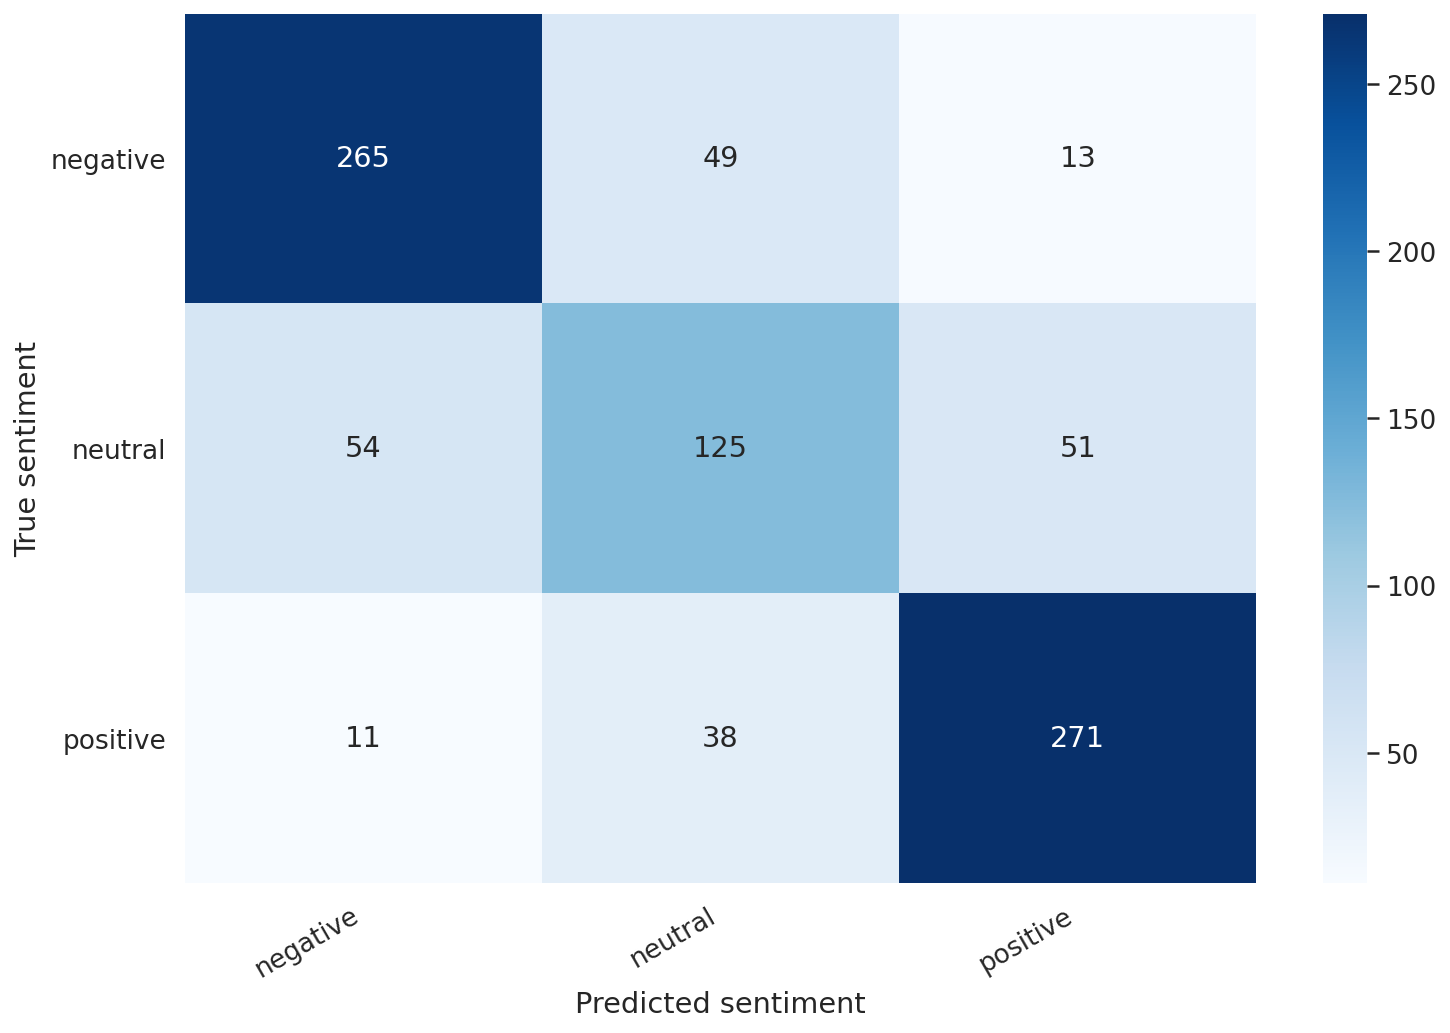

In [67]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [68]:
idx = 6

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame(
    {
        'class_names': class_names,
        'values': y_pred_probs[idx]
    }
)

In [69]:
from textwrap import wrap
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Está buena pero los filtros de Amazon cuando tiene muchas opciones no
scrollea

True sentiment: positive


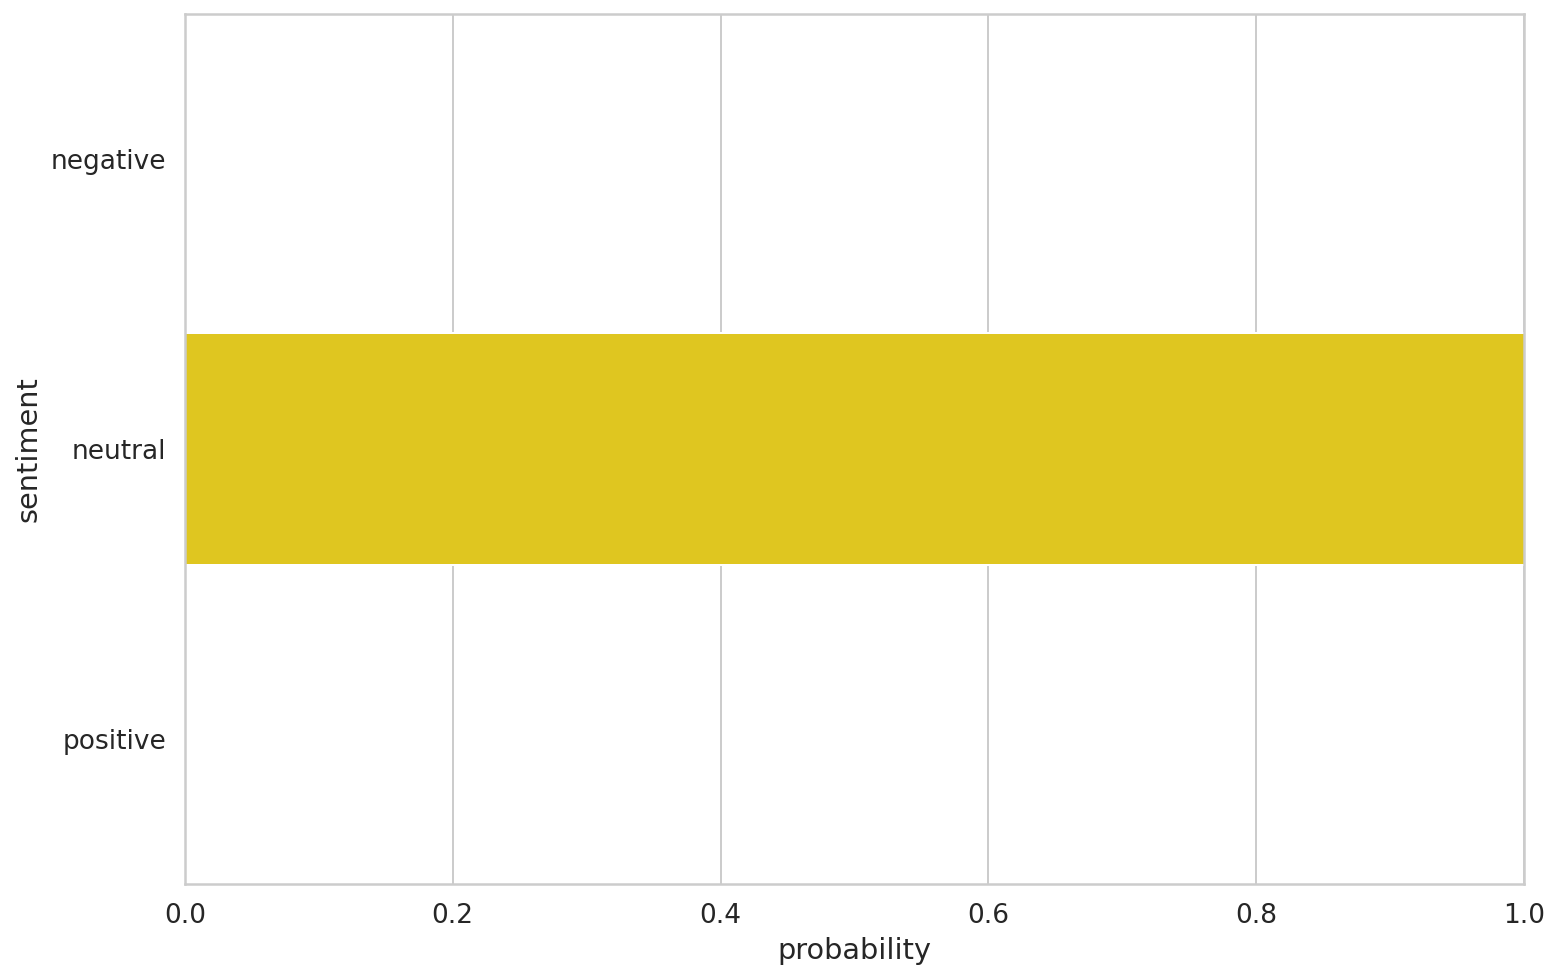

In [70]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Predict Sentiment on Raw Text

In [76]:
review_text = 'Me gusta pero tiene algunas cosas en las que podria mejorar'

In [77]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

In [78]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

In [79]:
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

In [80]:
print(f'Review text: {review_text}')
print(f'Sentiment: {class_names[prediction]}')

Review text: Me gusta pero tiene algunas cosas en las que podria mejorar
Sentiment: neutral
